In [8]:
import numpy as np
import mygrad as mg
import matplotlib.pyplot as plt
import matplotlib.mlab as lab
import librosa

In [38]:
songs = np.load("data/song_fourier_2000.npy")
data = np.load("data/songs.npz")
ids = data["data_id"][:1000]
genres = data["data_y"][:1000]
mapping = data["mapping"]

In [39]:
print(mapping)

['Pop' 'Rock' 'Hip-Hop' 'Electronic' 'International' 'Instrumental'
 'Experimental' 'Folk']


In [12]:
# cleaning data up
to_delete = [396, 557]
genres = np.delete(genres, to_delete, axis=0)
ids = np.delete(ids, to_delete, axis=0)

In [13]:
data_x = songs
data_y = genres
idxs = np.random.permutation(len(data_x))
data_x = data_x[idxs]
data_y = data_y[idxs]
ids = ids[idxs]

In [29]:
data_x = np.reshape(data_x, (len(data_x), 1, data_x.shape[-2], data_x.shape[-1]))
data_x = data_x[:,:,:100,:]
data_x.shape

(998, 1, 100, 3500)

In [30]:
mean = np.mean(data_x, axis=0)
std = np.std(data_x, axis=0)

data_x = (data_x - mean + 10e-8) / std

In [31]:
N = len(data_x)
train_x = data_x[:N//4*3]
train_y = data_y[:N//4*3]
test_x = data_x[N//4*3:]
test_y = data_y[N//4*3:]

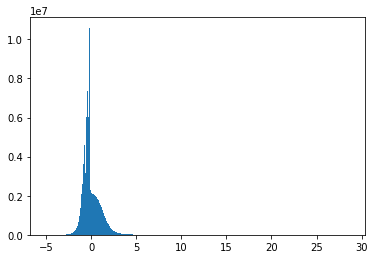

In [49]:
fig, ax = plt.subplots()
ax.hist(train_x.flatten(),bins=1000);

In [50]:
from mynn.layers.dense import dense
from mynn.layers.dropout import dropout
from mynn.layers.conv import conv
from mynn.initializers.glorot_normal import glorot_normal
from mynn.activations.relu import relu
from mygrad.nnet.layers import max_pool
from functools import reduce
class NN:
    init = glorot_normal
    def __init__(self):
        self.conv1 = conv(1,64,2,5,stride=[2,5],weight_initializer=NN.init)
        self.conv2 = conv(64,128,4,5,stride=[3,5],weight_initializer=NN.init)
        self.conv3 = conv(128,256,2,5,stride=[2,5],weight_initializer=NN.init)
        self.dense1 = dense(512,128,weight_initializer=NN.init)
        self.dense2 = dense(128,8,weight_initializer=NN.init)
    def __call__(self,X):
        X = relu(self.conv1(X)) # relu
        X = max_pool(X, [2,7], [2,7])
        X = relu(self.conv2(X))
        X = max_pool(X, [2,4], [2,4])
        X = relu(self.conv3(X))
        X = X.reshape(len(X),256*2*1)
        X = relu(self.dense1(X))
        X = self.dense2(X)
        return X
    
    @property
    def parameters(self):
        layers = [self.conv1, self.conv2, self.conv3]
        return reduce(lambda a,b: a+b, [layer.parameters for layer in layers])

In [86]:
import torch
from torch import nn
import torch.nn.functional as F
class NN_Py(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, (2,5), stride=(2,5))
        self.conv2 = nn.Conv2d(32, 64, (4,5), stride=(3,5))
        self.conv3 = nn.Conv2d(64, 128, (2,5), stride=(2,5))
        self.linear1 = nn.Linear(128*2*1, 128)
        self.linear2 = nn.Linear(128,8)

        for layer in (self.conv1, self.conv2, self.conv3, self.linear1, self.linear2):
            nn.init.xavier_normal_(layer.weight, np.sqrt(2))
            nn.init.constant_(layer.bias, 0)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), [2,7], stride=[2,7])
        x = F.dropout2d(x)
        x = F.max_pool2d(F.relu(self.conv2(x)), [2,4], stride=[2,4])
        x = F.dropout2d(x)
        x = F.relu(self.conv3(x))
        x = x.reshape(len(x),128*2*1)
        
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        
        return x

<IPython.core.display.Javascript object>


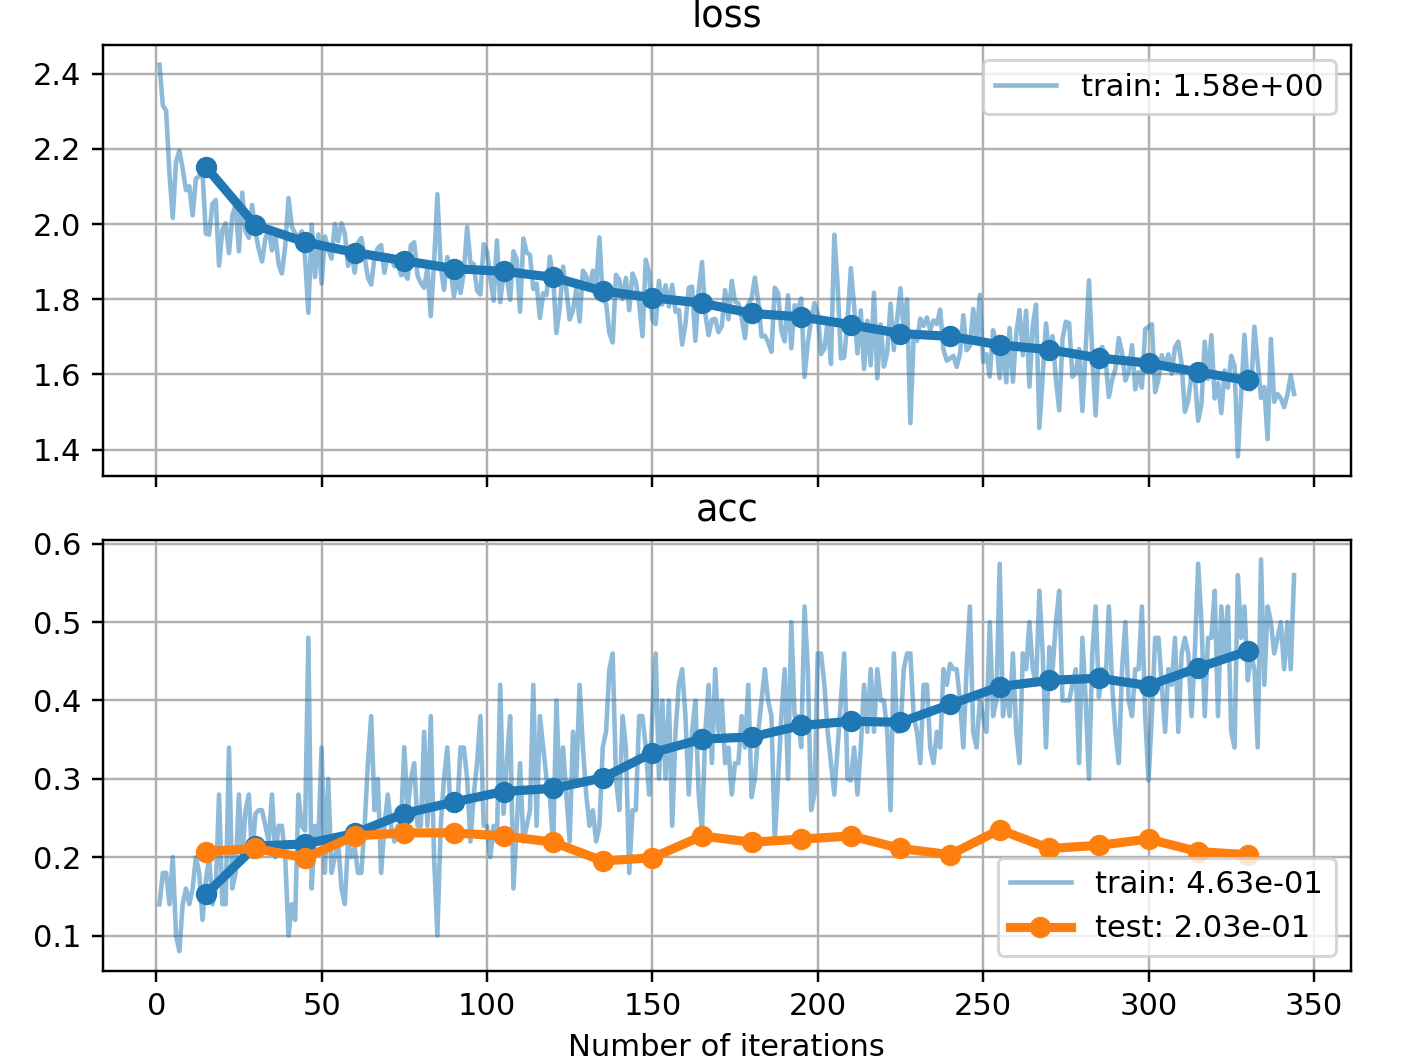

In [87]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = NN_Py().to(device)
from liveplot import create_plot
%matplotlib notebook
plotter, fix, ax = create_plot({'loss':None, 'acc':None}, 2)

In [88]:
optim = torch.optim.Adam(model.parameters(), 1e-04, weight_decay=5e-04)

batch_size = 50
torch.set_grad_enabled(True)

for i in range(300):
    ''' Train the model for one epoch. '''
    idxs = np.arange(len(train_x)) # randomize our batches
    np.random.shuffle(idxs)
    
    for batch in range(0, len(train_x), batch_size):
        batch_data = train_x[idxs[batch:batch+batch_size]]
        batch_labels = train_y[idxs[batch:batch+batch_size]]
        batch_labels = torch.tensor(batch_labels)
        model.train()
        outs = model(torch.tensor(batch_data,dtype=torch.float).to(device))  
        #print(outs)
        loss_func = nn.CrossEntropyLoss()
        
        loss = loss_func(outs, batch_labels) # compute the loss
        
        loss.backward()                                  # backpropagate
        optim.step()                                     # optimize the model
        optim.zero_grad()                                 # clear the gradient
        
        # keep track of training statistics
        correct = (outs.data.argmax(dim=1).numpy() == batch_labels.numpy()).sum()
        plotter.set_train_batch({'loss': loss.data, 'acc': correct / len(outs)}, len(outs))
    
    idxs = np.arange(len(test_x))
    np.random.shuffle(idxs)
    
    for batch in range(0, len(test_x), batch_size):
        batch_data = test_x[idxs[batch:batch+batch_size]]
        batch_labels = test_y[idxs[batch:batch+batch_size]]
        batch_labels = torch.tensor(batch_labels)
        model.eval()
        outs = model(torch.tensor(batch_data,dtype=torch.float).to(device))  
        
        correct = (outs.data.argmax(dim=1).numpy() == batch_labels.numpy()).sum()
        plotter.set_test_batch({'acc': correct / len(outs)}, len(outs))
    plotter.plot_train_epoch()
    plotter.plot_test_epoch()

KeyboardInterrupt: 